<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/RevolutPortfolioNewAssets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22411 sha256=50ac9d05916b31568a0e686a4efe026b0a94949d74d4715062a9c1e8dc158837
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, spearmanr

import requests
from bs4 import BeautifulSoup

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3)

In [0]:
def momentumBuy(close, asset='Asset', step=50, output='current', chart=False, printOut=False):
    shortBuy = close > close.rolling(step).mean()
    mediumBuy = close > close.rolling(step * 2).mean()
    longBuy = close > close.rolling(step * 4).mean()

    medMBuy = close.rolling(step).mean() > close.rolling(step * 2).mean()
    longMBuy = close.rolling(step).mean() > close.rolling(step * 4).mean()

    veryLongBuy = close.rolling(step * 2).mean() > close.rolling(200).mean()

    buySignals = pd.DataFrame(index=close.index)

    buySignals['BuySS'] = shortBuy
    buySignals['BuySM'] = mediumBuy
    buySignals['BuySL'] = longBuy
    buySignals['BuyMM'] = medMBuy
    buySignals['BuyML'] = longMBuy
    buySignals['BuyLL'] = veryLongBuy

    ts = pd.DataFrame({asset:close.div(close.iloc[0]),
                    'Returns':np.log(close/close.shift(1)),
                    'BuySignal':buySignals.sum(axis=1)},
                    index=close.index)

    momSum = ts.groupby('BuySignal')['Returns'].sum()
    momMed = ts.groupby('BuySignal')['Returns'].median()
    buySigns = []
    holdSignal = []
    sellSign = []
    losingSignals = momSum[momSum <= 0.0].index

    for bl in range(len(buySignals.columns),0,-1):        
        if np.logical_and(momSum[bl] > 0.0, bl > max(losingSignals)):
            buySigns.append(bl)
        elif momSum[bl] > 0.0:
            holdSignal.append(bl)
        elif momMed[bl] <= 0.0:
            sellSign.append(bl)

    ts['Signal'] = ''
    ts.loc[ts[ts['BuySignal'] == 0].index, 'Signal'] = 'SELL'
    
    if len(buySigns) > 1:
        for buy in buySigns:
            ts.loc[ts[ts['BuySignal'] == buy].index, 'Signal'] = 'BUY'
    elif len(buySigns) == 1:
        ts.loc[ts[ts['BuySignal'] == buySigns[0]].index, 'Signal'] = 'BUY'
        
    if len(holdSignal) > 1:
        for hold in holdSignal:
            ts.loc[ts[ts['BuySignal'] == hold].index, 'Signal'] = 'HOLD'
    elif len(holdSignal) == 1:
        ts.loc[ts[ts['BuySignal'] == holdSignal[0]].index, 'Signal'] = 'HOLD'

    if len(sellSign) > 1:
        for sell in sellSign:
            ts.loc[ts[ts['BuySignal'] == sell].index, 'Signal'] = 'SELL'
    elif len(sellSign) == 1:
        ts.loc[ts[ts['BuySignal'] == sellSign[0]].index, 'Signal'] = 'SELL'

    for b in buySignals.columns:    
        rets = ts['Returns'][buySignals[b]]
        prob = rets[rets > 0.0].count()/rets.count()    
        if printOut: print(b, prob, rets.mean());

        ts[b] = 0
        ts.loc[buySignals[buySignals[b]].index, b] = 1

    if chart:
        ts['2018':][[asset,'BuySignal']].plot(figsize=(16,8))
        plt.show();

    if printOut: print(ts.groupby('BuySignal')['Returns'].mean());
    
    for i in range(6):
        minpick = ts.loc[ts[ts['BuySignal'] >= i].index]
        probs = minpick.groupby('BuySignal')['Returns'].count()/minpick['Returns'].count()    
        rets = minpick.groupby('BuySignal')['Returns'].mean()
        std = minpick.groupby('BuySignal')['Returns'].std()

        dprobs = minpick[minpick['Returns'] < 0.0].groupby('BuySignal')['Returns'].count()/minpick.groupby('BuySignal')['Returns'].count()
        #print((probs * rets).sum())
        #print(dprobs)
    
    ts['LAG.14'] = ts['Returns'].shift(14).rolling(14).sum()
    ts['LAG.28'] = ts['Returns'].shift(28).rolling(28).sum()
    ts['LAG.60'] = ts['Returns'].shift(60).rolling(60).sum()
    ts['LAG.90'] = ts['Returns'].shift(90).rolling(90).sum()
    lags = ['LAG.14','LAG.28','LAG.60','LAG.90']
    
    signalProbs = pd.DataFrame(index=list(range(len(list(itertools.product([1, 0], 
                                                                           repeat = len(buySignals.columns)))))),
                               columns=list(buySignals.columns) + lags)
    signalProbs[buySignals.columns] = 0
    signalProbs[lags] = 0.0

    signalReturns = pd.DataFrame(index=list(range(len(list(itertools.product([1, 0], 
                                                                           repeat = len(buySignals.columns)))))),
                               columns=list(buySignals.columns) + lags)
    signalReturns[buySignals.columns] = 0
    signalReturns[lags] = 0.0

    i = 0
    for comb in itertools.product([1, 0], repeat = len(buySignals.columns)):
        comb = list(comb)
        signalProbs.loc[i, buySignals.columns] = comb

        signInd = buySignals[buySignals == comb].dropna().index
        signRets = ts[lags].reindex(signInd)
        theProbs = signRets[signRets > 0.07/step].count()/signRets.count()
        #print(comb)
        #print(buySignals[buySignals == comb].dropna().tail())
        #print(theProbs)
        signalProbs.loc[i, lags] = theProbs
        signalReturns.loc[i, lags] = signRets.median()
        i += 1
    
    for ss in buySignals.columns:
        rets = ts[ts[ss] == 1][lags].dropna()
        prob = rets[rets > 0.01].count()/rets.count()
        hrets = rets[rets > 0.01].mean()

        if printOut:
            print('\n',ss)
            print(rets.mean(), '\n',rets.median())
            print('\nProbabilities:')
            print(prob.mean())
            print((prob * hrets).mean())
    
    if printOut: print(ts.groupby('Signal')['Returns'].mean());
    
    if output == 'current' or output == 'single':
        currentState = (np.array(signalProbs[buySignals.columns].values) == np.array(ts[buySignals.columns].iloc[-1].values)).sum(axis=1) == len(buySignals.columns)
        lagOutput = []
        for lagProb in lags:
            action = ''
            if signalProbs[currentState][lagProb].values[0] > 0.75: action = 'BUY'
            elif signalProbs[currentState][lagProb].values[0] > 0.50: action = 'HOLD'
            elif signalProbs[currentState][lagProb].values[0] <= 0.50: action = 'SELL'

            lagOutput.append([lagProb, action, 
                            signalProbs[currentState][lagProb].values[0], 
                            signalReturns[currentState][lagProb].values[0]])

            if printOut:
                print(lagProb, action, 
                    round(100*signalProbs[currentState][lagProb].values[0],1),
                    round(100*signalReturns[currentState][lagProb].values[0],3))                
        
        if output == 'single':
            ttemp = pd.DataFrame(lagOutput)        
            return ttemp.loc[ttemp[2].idxmin(), 1]
        else:
            return lagOutput

    elif output == 'ts':
        return ts

a = 'OKE'
pps = yf.download(a)['Adj Close']
#print(pps.tail())
timeSeries = momentumBuy(pps, asset=a, output='ts')
print('Current state {}\n\n'.format(timeSeries['BuySignal'].iloc[-1]), 
      timeSeries.groupby(['Signal','BuySignal'])['Returns'].mean())

print(pd.DataFrame(momentumBuy(pps, asset=a, output='current'),
                   columns=list(['LAG','Signal','Profit Prob.','Return'])))

momentumBuy(pps, asset=a, output='single')

[*********************100%***********************]  1 of 1 completed
Current state 6

 Signal  BuySignal
BUY     5            0.000383
        6            0.003045
HOLD    3            0.000329
SELL    0           -0.002657
        1           -0.000116
        2           -0.001749
        4           -0.000528
Name: Returns, dtype: float64
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.730888  0.033902
1  LAG.28    BUY      0.804497  0.057548
2  LAG.60    BUY      0.853018  0.110587
3  LAG.90    BUY      0.832899  0.137053


'HOLD'

In [0]:
portfolio = ['T', 'PFE','FB','MSFT','AMTD']
candidates = ['AAPL','ABBV','ABT','ACN','ADI','AGM','AGNC','ALB','AMTD','AMZN',
              'APD','ARR','AVAL','BABA','BAH','BEN','BLK','CAH','CATY','CBT',
              'CCBG','CCL','CHD','CHRW','CFG','CL','CMA','CNI','CMCSA','COST',
              'CSCO','CVS','CVX','D','DDS','DUK','DX','EBF','EMR','ENB','EPD',
              'EPR','ES','FAST','FB','FDX','FITB','FRT','FLIC','FLO','GIS','GGG',
              'GOOG','GS','GWB','HBAN','IBCP','IBM','IMBBY','INTC','IRM','JNJ',
              'JPM','K','KEY','KMB','KO','LMT','LOW','MA','MAIN','MBWM','MCY','MCD',
              'MDP','MDT','MED','MNRL','MMM','MMP','MO','MPLX','MSFT','MSI','MSM','NHI','NFLX',
              'NNN','NKE','NJR','NRIM','NTAP','O','OC','OKE','OZK','PEBO','PEP',
              'PFG','PG','PII','PLD','PM','PNC','PRU','RCL','RGLD','RNR','RF',
              'SBUX','SKT','SNV','SO','SPG','STAG','SWM','TGT','TM',
              'TSLA','TWO','TXN','UHT','UNH','UNM','UVV','V','VGR','VZ','WBA','WBS','WELL',
              'WEN','WFC','WM','WLK','WMT','XOM','YORW']

assets = pd.Series(portfolio + candidates).drop_duplicates().to_list()
print('\nCheck for duplicates!')
np.sort(candidates)


Check for duplicates!


array(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADI', 'AGM', 'AGNC', 'ALB', 'AMTD',
       'AMZN', 'APD', 'ARR', 'AVAL', 'BABA', 'BAH', 'BEN', 'BLK', 'CAH',
       'CATY', 'CBT', 'CCBG', 'CCL', 'CFG', 'CHD', 'CHRW', 'CL', 'CMA',
       'CMCSA', 'CNI', 'COST', 'CSCO', 'CVS', 'CVX', 'D', 'DDS', 'DUK',
       'DX', 'EBF', 'EMR', 'ENB', 'EPD', 'EPR', 'ES', 'FAST', 'FB', 'FDX',
       'FITB', 'FLIC', 'FLO', 'FRT', 'GGG', 'GIS', 'GOOG', 'GS', 'GWB',
       'HBAN', 'IBCP', 'IBM', 'IMBBY', 'INTC', 'IRM', 'JNJ', 'JPM', 'K',
       'KEY', 'KMB', 'KO', 'LMT', 'LOW', 'MA', 'MAIN', 'MBWM', 'MCD',
       'MCY', 'MDP', 'MDT', 'MED', 'MMM', 'MMP', 'MNRL', 'MO', 'MPLX',
       'MSFT', 'MSI', 'MSM', 'NFLX', 'NHI', 'NJR', 'NKE', 'NNN', 'NRIM',
       'NTAP', 'O', 'OC', 'OKE', 'OZK', 'PEBO', 'PEP', 'PFG', 'PG', 'PII',
       'PLD', 'PM', 'PNC', 'PRU', 'RCL', 'RF', 'RGLD', 'RNR', 'SBUX',
       'SKT', 'SNV', 'SO', 'SPG', 'STAG', 'SWM', 'TGT', 'TM', 'TSLA',
       'TWO', 'TXN', 'UHT', 'UNH', 'UNM', 'UVV', 'V', 'VGR',

In [0]:
data = yf.download(assets, period='10y').sort_index().resample('D').last()

prices = data['Adj Close'].fillna(method="ffill")
close = data['Close'].fillna(method="ffill")

(prices.count()[prices.count() < prices.count().quantile(0.05)]/365).sort_values()

[*********************100%***********************]  140 of 140 completed


MNRL    0.715068
CFG     5.282192
AVAL    5.284932
BABA    5.295890
ABBV    7.008219
MPLX    7.194521
FB      7.635616
dtype: float64

In [0]:
for a in prices.count()[prices.isna().sum() > 3*365].index:
    if a not in portfolio:
        prices = prices.drop(a, axis=1)
        print('Droping ' + a + ' for lack of historical prices.')

Droping AVAL for lack of historical prices.
Droping BABA for lack of historical prices.
Droping CFG for lack of historical prices.
Droping MNRL for lack of historical prices.


In [0]:
for a in portfolio:
    print(a)
    print(pd.DataFrame(momentumBuy(prices[a], a, 
                                   output='current'),
                       columns=list(['LAG','Signal','Profit Prob.','Return'])))

T
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.728718  0.014807
1  LAG.28    BUY      0.772685  0.028073
2  LAG.60    BUY      0.852198  0.052678
3  LAG.90   HOLD      0.736202  0.046341
PFE
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.692771  0.011832
1  LAG.28   HOLD      0.716867  0.025250
2  LAG.60   HOLD      0.506024  0.001883
3  LAG.90   SELL      0.192771 -0.061439
FB
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.693309  0.020390
1  LAG.28    BUY      0.828996  0.039858
2  LAG.60    BUY      0.762082  0.064740
3  LAG.90   HOLD      0.720260  0.072991
MSFT
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.726704  0.016960
1  LAG.28    BUY      0.817386  0.031800
2  LAG.60    BUY      0.834897  0.048216
3  LAG.90    BUY      0.826767  0.067195
AMTD
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD        0.6875  0.013751
1  LAG.28    BUY        1.0000  0.060639
2  LAG.60   SELL        0.2500 -0.0211

In [0]:
mret = prices.pct_change(28).fillna(0.0)
mret['Portfolio'] = mret[portfolio].mean(axis=1)

mlogret = np.log(prices/prices.shift(1)).rolling(28).sum().fillna(0.0)
mlogret['Portfolio'] = mlogret[portfolio].mean(axis=1)

mlogret['Portfolio'].describe()

count    3650.000000
mean        0.010841
std         0.036313
min        -0.133160
25%        -0.008717
50%         0.013799
75%         0.033990
max         0.140171
Name: Portfolio, dtype: float64

In [0]:
profiles = pd.DataFrame(columns=list(['Name', 'Industry', 'Sub-Industry']), 
                        index=prices.columns, dtype=str)
profiles['Action'] = ''
profiles['Profit Prob.'] = 0.0
profiles['Beta'] = 0.0
profiles['RET'] = mret[profiles.index].mean().mul(12)
profiles['STD'] = mret[profiles.index].std().mul(np.sqrt(12))

i = 1
for a in prices.columns:
    try:
        profile_page = requests.get('https://finance.yahoo.com/quote/' + str(a) + '/profile?p=' + str(a))
        soup = BeautifulSoup(profile_page.content, 'html.parser')

        #print(a)

        profiles.loc[a, 'Name'] = soup.find('h3', {'class':"Fz(m) Mb(10px)"}).text

        for span in soup.find_all('span', {'class':'Fw(600)'}):
            if str(span).find('data-reactid="21"') > 0: 
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="22"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="23"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
        
            if str(span).find('data-reactid="25"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="26"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="27"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
        
        aact = momentumBuy(prices[a], asset=a, output='single')
        curr = momentumBuy(prices[a], asset=a, output='current')
        
        profiles.loc[a, 'Action'] = aact
        profiles.loc[a, 'Profit Prob.'] = round(100*curr[1][2],2)
        
    except:
        print(a)
        profiles = profiles.drop(a)
        prices = prices.drop(a, axis=1)

    proc = round(i/len(prices.columns),3)
    #print(i, proc, proc % 0.1)
    if proc % 0.1 >= 0.095:
        print('{}% processed.'.format(100 * proc))
    i += 1

profiles.info()

9.6% processed.
19.900000000000002% processed.
39.7% processed.
50.0% processed.
59.599999999999994% processed.
69.89999999999999% processed.
89.7% processed.
100.0% processed.
<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, AAPL to YORW
Data columns (total 8 columns):
Name            136 non-null object
Industry        136 non-null object
Sub-Industry    136 non-null object
Action          136 non-null object
Profit Prob.    136 non-null float64
Beta            136 non-null float64
RET             136 non-null float64
STD             136 non-null float64
dtypes: float64(4), object(4)
memory usage: 14.6+ KB


In [0]:
profiles['Beta'] = mlogret.cov()['Portfolio']/mlogret.drop('Portfolio', axis=1).var().loc[profiles.index]

In [0]:
ret = prices.pct_change().dropna()
wret = prices.asfreq(freq='W', method='ffill').pct_change().dropna()
wretRoll = prices.pct_change(7).dropna()

log_ret = np.log(prices.div(prices.shift(1))).fillna(0.0)
alog_ret = log_ret.rolling(365).sum()

ret['Portfolio'] = ret[portfolio].mean(axis=1)
log_ret['Portfolio'] = log_ret[portfolio].mean(axis=1).fillna(0.0)

In [0]:
#Need to add Price to Earnings and Price to Book to profiles
profiles.loc[portfolio]

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
T,AT&T Inc.,Communication Services,Telecom Services,HOLD,77.27,0.335030,0.097118,0.147506
PFE,Pfizer Inc.,Healthcare,Drug Manufacturers—General,SELL,71.69,0.452395,0.112970,0.159759
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,HOLD,82.90,0.234969,0.219595,0.295191
MSFT,Microsoft Corporation,Technology,Software—Infrastructure,HOLD,81.74,0.426160,0.192900,0.186472
AMTD,TD Ameritrade Holding Corporation,Financial Services,Capital Markets,SELL,100.00,0.333488,0.154113,0.282416


In [0]:
profiles.loc[mlogret[mlogret['Portfolio'] < 0.0].corr()['Portfolio'].sort_values().head(15).index].sort_values(by='Profit Prob.')

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
DUK,Duke Energy Corporation,Utilities,Utilities—Regulated Electric,SELL,3.45,0.074444,0.097950,0.131968,0.096437,0.148529
MMP,"Magellan Midstream Partners, L.P.",Energy,Oil & Gas Midstream,SELL,12.84,0.189396,0.172315,0.178923,0.171242,0.216941
NRIM,"Northrim BanCorp, Inc.",Financial Services,Banks—Regional,SELL,20.00,0.195270,0.128525,0.213474,0.111374,0.236600
RGLD,"Royal Gold, Inc.",Basic Materials,Gold,SELL,20.41,0.002380,0.168126,0.381821,0.102896,0.364208
NNN,"National Retail Properties, Inc.",Real Estate,REIT—Retail,SELL,29.70,0.097741,0.146788,0.178024,0.139400,0.197188
O,Realty Income Corporation,Real Estate,REIT—Retail,SELL,32.26,0.129862,0.150314,0.178663,0.147288,0.200615
MCD,McDonald's Corporation,Consumer Cyclical,Restaurants,SELL,39.71,0.237698,0.141991,0.126051,0.147993,0.155828
YORW,The York Water Company,Utilities,Utilities—Regulated Water,HOLD,71.99,0.106068,0.151392,0.185685,0.140464,0.255740
VGR,Vector Group Ltd.,Consumer Defensive,Tobacco,HOLD,75.13,0.147857,0.163070,0.198340,0.159355,0.218555
D,"Dominion Energy, Inc.",Utilities,Utilities—Diversified,HOLD,76.49,0.191359,0.115716,0.129787,0.115756,0.157619


In [0]:
portfolio_ind = profiles.loc[portfolio].groupby('Industry').count()['Name']
portfolio_subind = profiles.loc[portfolio].groupby('Sub-Industry').count()['Name']

print(portfolio_subind)
selection = profiles
industryCount = len(profiles.groupby('Industry').count().index)
subIndustryCount = len(profiles.groupby('Sub-Industry').count().index)

port_Ind_fully_invested = len(portfolio_ind.index) == industryCount
port_subInd_fully_invested = len(portfolio_subind.index) == subIndustryCount

for i in portfolio_ind.index:
    if port_Ind_fully_invested:
        if portfolio_ind.loc[i] == portfolio_ind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Industry'] != i]
for i in portfolio_subind.index:
    if port_subInd_fully_invested:
        if portfolio_subind.loc[i] == portfolio_subind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Sub-Industry'] != i]

selection = selection[selection['Action'] != 'SELL']

selection.sort_values(by=['Industry', 'Profit Prob.'])

Sub-Industry
Capital Markets                   1
Drug Manufacturers—General        1
Internet Content & Information    1
Software—Infrastructure           1
Telecom Services                  1
Name: Name, dtype: int64


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
PII,Polaris Inc.,Consumer Cyclical,Recreational Vehicles,HOLD,71.07,0.171204,0.208279,0.302797
WEN,The Wendy's Company,Consumer Cyclical,Restaurants,HOLD,75.09,0.228234,0.190371,0.233368
LOW,"Lowe's Companies, Inc.",Consumer Cyclical,Home Improvement Retail,HOLD,78.65,0.278489,0.196562,0.229189
RCL,Royal Caribbean Cruises Ltd.,Consumer Cyclical,Travel Services,HOLD,80.39,0.218184,0.215187,0.320147
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,83.09,0.077621,0.391841,0.507792
NKE,"NIKE, Inc.",Consumer Cyclical,Footwear & Accessories,HOLD,83.49,0.297356,0.215506,0.193523
KO,The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,HOLD,74.90,0.299070,0.105556,0.119790
VGR,Vector Group Ltd.,Consumer Defensive,Tobacco,HOLD,75.13,0.147857,0.163070,0.198340
PM,Philip Morris International Inc.,Consumer Defensive,Tobacco,HOLD,81.14,0.155910,0.114792,0.196200
K,Kellogg Company,Consumer Defensive,Packaged Foods,HOLD,82.07,0.174659,0.059594,0.143615


In [0]:
profiles.loc[['NKE','BAH','SO','TGT','K']]

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
NKE,"NIKE, Inc.",Consumer Cyclical,Footwear & Accessories,HOLD,83.49,0.297356,0.215506,0.193523,0.212081,0.236451
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,79.62,0.150844,0.202626,0.232984,0.190678,0.254037
SO,The Southern Company,Utilities,Utilities—Regulated Electric,HOLD,77.58,0.075623,0.111199,0.121774,0.112216,0.142288
TGT,Target Corporation,Consumer Defensive,Discount Stores,SELL,82.19,0.150644,0.138101,0.233191,0.119058,0.236722
K,Kellogg Company,Consumer Defensive,Packaged Foods,HOLD,82.07,0.174659,0.059594,0.143615,0.055321,0.177013


In [0]:
val = prices[selection.index].iloc[-1]/prices[selection.index].iloc[-365:].mean()
val = val[val < 1.0]
underVal = []

for a in val.index.to_list():
    if np.logical_and(prices[a].iloc[-3*365:].pct_change().mean() > 0.0,
                      a not in portfolio):
        underVal.append(a)

print('Currently assets under consideration:\n{}'.format(underVal))

Currently assets under consideration:
[]


In [0]:
if len(underVal) > 1:
    wretRoll[underVal].plot(subplots=True, figsize=(16,8))
    plt.show();
    wretRoll[underVal].mul(52).describe()

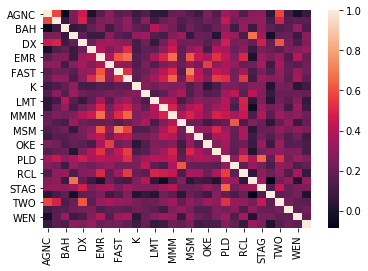

Lowest correlating assets:


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.65,0.131980,0.105678,0.149876
DDS,"Dillard's, Inc.",Consumer Cyclical,Department Stores,SELL,63.90,0.105673,0.209604,0.391688
DUK,Duke Energy Corporation,Utilities,Utilities—Regulated Electric,SELL,3.45,0.074444,0.097950,0.131968
ES,Eversource Energy,Utilities,Utilities—Regulated Electric,SELL,21.15,0.153671,0.147919,0.136744
RGLD,"Royal Gold, Inc.",Basic Materials,Gold,SELL,20.41,0.002380,0.168126,0.381821
SO,The Southern Company,Utilities,Utilities—Regulated Electric,HOLD,77.58,0.075623,0.111199,0.121774
WELL,Welltower Inc.,Real Estate,REIT—Healthcare Facilities,SELL,23.66,0.081940,0.122328,0.193068


In [0]:
selAss = selection.index.to_list()
low_corr = ret.corr()[ret.corr()['Portfolio'] <= ret.corr()['Portfolio'].quantile(0.05)]

sns.heatmap(mlogret.corr().loc[selAss, selAss])
plt.show();

print('Lowest correlating assets:')
profiles.loc[low_corr.index]

In [0]:
sel = selection.index.to_list()[:]
sel.append('Portfolio')

sel_corr = ret[sel].corr()['Portfolio']
print(sel_corr.sort_values().head(10))

diversifiedPicks = sel_corr.sort_values()[sel_corr<sel_corr.quantile(0.25)].index.to_list()

SO      0.151064
AGNC    0.210534
D       0.228007
ARR     0.264067
K       0.269830
DX      0.288289
YORW    0.293197
TWO     0.295069
VGR     0.303953
EBF     0.304704
Name: Portfolio, dtype: float64


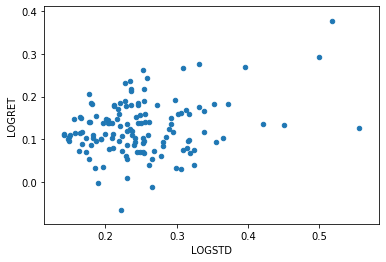

In [0]:
profiles['LOGRET'] = log_ret.mean().mul(365)
profiles['LOGSTD'] = log_ret.std().mul(np.sqrt(365))

profiles.plot(kind='scatter', x='LOGSTD', y='LOGRET')#, size='Beta')
plt.show()

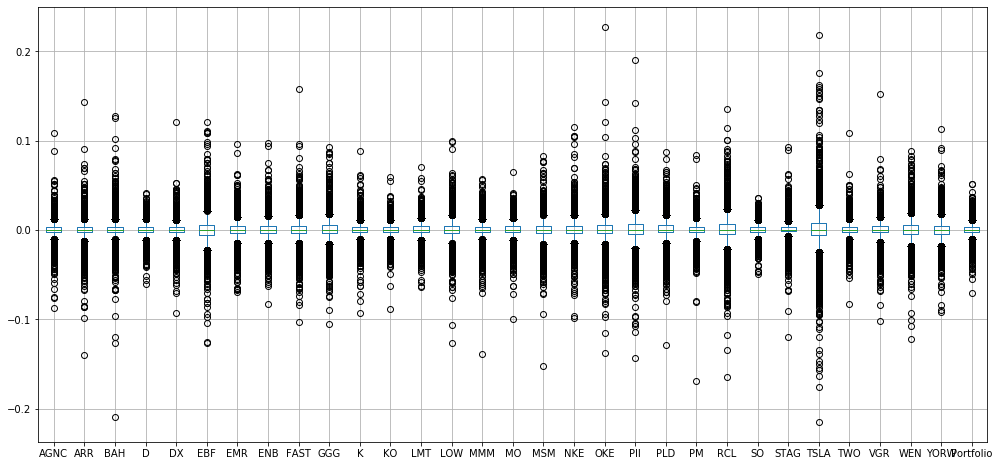

AGNC: 12.99%, 14.14%, 0.92
ARR: 10.2%, 14.42%, 0.71
BAH: 14.44%, 15.0%, 0.96
D: 13.19%, 14.16%, 0.93
DX: 11.23%, 14.49%, 0.77
EBF: 12.41%, 16.02%, 0.77
EMR: 12.71%, 15.65%, 0.81
ENB: 13.07%, 14.95%, 0.87
FAST: 13.6%, 15.72%, 0.87
GGG: 14.87%, 15.86%, 0.94
K: 12.18%, 14.24%, 0.86
KO: 13.0%, 14.29%, 0.91
LMT: 14.69%, 14.74%, 1.0
LOW: 14.26%, 15.43%, 0.92
MMM: 12.95%, 15.21%, 0.85
MO: 13.61%, 14.44%, 0.94
MSM: 12.44%, 15.41%, 0.81
NKE: 14.79%, 15.35%, 0.96
OKE: 14.45%, 15.9%, 0.91
PII: 14.19%, 16.3%, 0.87
PLD: 13.89%, 15.54%, 0.89
PM: 12.93%, 14.59%, 0.89
RCL: 14.3%, 16.91%, 0.85
SO: 13.13%, 13.81%, 0.95
STAG: 13.73%, 14.8%, 0.93
TSLA: 16.12%, 17.52%, 0.92
TWO: 12.72%, 14.37%, 0.89
VGR: 13.91%, 14.7%, 0.95
WEN: 14.27%, 15.34%, 0.93
YORW: 13.6%, 15.08%, 0.9
Portfolio: 13.51%, 15.66%, 0.86

Based on Return/Risk ratio, best pick would be ['BAH', 'LMT', 'MO', 'NKE', 'SO', 'VGR']
Based on lowest portfolio Risk, best pick would be ['AGNC', 'D', 'K', 'KO', 'SO', 'TWO']


In [0]:
log_ret[sel].boxplot(figsize=(17,8))
plt.show()

candidatesSeries = pd.Series(index=sel)
riskSeries = pd.Series(index=sel)
for n in sel:
    t = portfolio[:]
    t.append(n)
    
    mu = log_ret[t].mean(axis=1).mean()*365
    cov = log_ret[t].cov()
    w = np.ones(len(t))
    w /= np.sum(w)
    risk = np.sqrt(365 * np.dot(w.T, np.dot(cov, w)))

    riskSeries.loc[n] = risk
    candidatesSeries.loc[n] = mu/risk
    print('{}: {}%, {}%, {}'.format(n, round(100*mu,2), 
                                    round(100*risk,2), 
                                    round(mu/risk, 2)))

bestSH = candidatesSeries[candidatesSeries > candidatesSeries['Portfolio']]
bestSH = bestSH[bestSH > bestSH.quantile(0.75)].index.to_list()

lowestRisk = riskSeries[riskSeries < riskSeries['Portfolio']]
lowestRisk = lowestRisk[lowestRisk < lowestRisk.quantile(0.25)].index.to_list()

print('\nBased on Return/Risk ratio, best pick would be {}'.format(bestSH))
print('Based on lowest portfolio Risk, best pick would be {}'.format(lowestRisk))

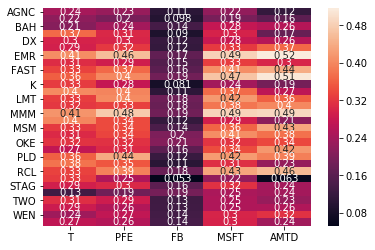

SO      0.211985
AGNC    0.222800
ARR     0.249056
TWO     0.267344
D       0.287982
DX      0.290600
TSLA    0.296729
STAG    0.308358
K       0.308545
YORW    0.316264
dtype: float64

Based on correlations, best picks would be:


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
ARR,"ARMOUR Residential REIT, Inc.",Real Estate,REIT—Mortgage,HOLD,83.44,0.191445,-0.034199,0.195898,-0.063546,0.222153
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,83.09,0.077621,0.391841,0.507792,0.292013,0.499129
STAG,"STAG Industrial, Inc.",Real Estate,REIT—Industrial,HOLD,81.02,0.259681,0.151764,0.192982,0.148653,0.215896
TWO,Two Harbors Investment Corp.,Real Estate,REIT—Mortgage,HOLD,80.35,0.263998,0.094112,0.148542,0.087953,0.180300
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.65,0.131980,0.105678,0.149876,0.104275,0.182764
SO,The Southern Company,Utilities,Utilities—Regulated Electric,HOLD,77.58,0.075623,0.111199,0.121774,0.112216,0.142288
D,"Dominion Energy, Inc.",Utilities,Utilities—Diversified,HOLD,76.49,0.191359,0.115716,0.129787,0.115756,0.157619
DX,"Dynex Capital, Inc.",Real Estate,REIT—Mortgage,HOLD,64.11,0.276872,0.009541,0.158401,-0.001761,0.189638


In [0]:
sns.heatmap(log_ret.corr(method='pearson').loc[selection.index, portfolio], annot=True)
plt.show()

bestPick = pd.Series(data=np.zeros(len(selection.index)), index=selection.index)

for b in bestPick.index:
    pear = pearsonr(log_ret['Portfolio'], log_ret[b])
    spear = spearmanr(log_ret['Portfolio'], log_ret[b])

    pSum = pear[1]+spear[1]
    if np.logical_and(pear[1]<0.05, spear[1]<0.05):
        bestPick.loc[b] = pear[0]*pear[1]/pSum + spear[0]*spear[1]/pSum
    elif pear[1]<0.05:
        bestPick.loc[b] = pear[0]
    elif spear[1]<0.05:
        bestPick.loc[b] = spear[0]

bestPick = bestPick.dropna()
bestCOR = bestPick[bestPick < bestPick.quantile(0.25)].sort_values().index.to_list()

print(bestPick.sort_values().head(10))
print('\nBased on correlations, best picks would be:')#\n{}'.format(bestCOR))

profiles.loc[bestCOR].sort_values(by='Profit Prob.', ascending=False)

In [0]:
n = 100
simRet = pd.DataFrame(columns=sel, index=list(range(n)))
simRisk = pd.DataFrame(columns=sel, index=list(range(n)))

for asset in sel:
    simRet[asset] = 0.0
    simRisk[asset] = 0.0

    for i in range(n):
        mu = ret[asset].mean()
        sigma = ret[asset].std()
        
        simulations = (np.ones(n*365) * mu -(sigma**2)/2) + np.random.standard_normal(n*365) * sigma
        
        simRet.loc[i, asset] = np.mean(simulations) * 365
        simRisk.loc[i, asset] = np.std(simulations) * np.sqrt(365)


bestRisk = simRisk.mode().median().sort_values()
bestRisk = bestRisk[bestRisk < bestRisk.quantile(0.25)]

bestReturns = simRet.mode().median()
bestReturns = bestReturns[bestReturns>bestReturns.quantile(0.75)]

bestSharpe = bestReturns/bestRisk
bestSharpe = bestSharpe[bestSharpe > bestSharpe.quantile(0.75)].sort_values(ascending=False)

if 'Portfolio' in bestSharpe.index: bestSharpe = bestSharpe.drop('Portfolio')
if 'Portfolio' in bestRisk.index: bestRisk = bestRisk.drop('Portfolio')
if 'Portfolio' in bestReturns.index: bestReturns = bestReturns.drop('Portfolio')

bestReturns.sort_values(ascending=False)

TSLA    0.355107
BAH     0.247825
WEN     0.244516
LMT     0.244446
NKE     0.211778
RCL     0.209586
GGG     0.194016
dtype: float64

In [0]:
invetable = []

if len(bestSH)>=1:
    #print('\nBased on Return/Risk ratio, best picks would be:')
    for p in bestSH:
        #print(p)
        invetable.append(p)

if len(lowestRisk)>=1:
    #print('\nBased on Risk, best picks would be:')
    for p in lowestRisk:
        #print(p)
        invetable.append(p)

if len(bestCOR)>=1:
    #print('\nBased on correlations, best picks would be:')
    for p in bestCOR:
        #print(p)
        invetable.append(p)

if len(underVal)>=1:
    #print('\nBased on historical prices these stocks seam undervalued:')
    for p in underVal:
        #print(p)
        invetable.append(p)

try:
    if len(bestSharpe.index)>=1:
        #print('\nBased on simulated Return/Risk ratio, best picks would be:')        
        for p in bestSharpe.index.to_list():
            #print(p)
            invetable.append(p)

    if len(bestRisk.index):
        #print('\nBased on simulated Risk, best picks would be:')        
        for p in bestRisk.index.to_list():
            #print(p)
            invetable.append(p)

    if len(bestReturns.index)>=1:
        #print('\nBased on simulated Return, best picks would be:')        
        for p in bestReturns.index.to_list():
            #print(p)
            invetable.append(p)
except:
    print('\nNo simulations were made.')
    
invDF = pd.DataFrame(invetable).groupby(0)[0].count()
print('\nMost frequently picked assets:')
profiles.loc[invDF.sort_values(ascending=False)[invDF==invDF.max()].index]


Most frequently picked assets:


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
0,,,,,,,,,,
LMT,Lockheed Martin Corporation,Industrials,Aerospace & Defense,HOLD,80.93,0.366943,0.195659,0.159923,0.205693,0.177099
SO,The Southern Company,Utilities,Utilities—Regulated Electric,HOLD,77.58,0.075623,0.111199,0.121774,0.112216,0.142288


In [0]:
selection[selection['Beta'] <= selection['Beta'].quantile(0.25)].sort_values(by='Profit Prob.',
                                                                             ascending=False)

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,83.09,0.077621,0.391841,0.507792
PM,Philip Morris International Inc.,Consumer Defensive,Tobacco,HOLD,81.14,0.155910,0.114792,0.196200
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.65,0.131980,0.105678,0.149876
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,79.62,0.150844,0.202626,0.232984
OKE,"ONEOK, Inc.",Energy,Oil & Gas Midstream,BUY,79.49,0.162251,0.214230,0.282743
SO,The Southern Company,Utilities,Utilities—Regulated Electric,HOLD,77.58,0.075623,0.111199,0.121774
VGR,Vector Group Ltd.,Consumer Defensive,Tobacco,HOLD,75.13,0.147857,0.163070,0.198340
YORW,The York Water Company,Utilities,Utilities—Regulated Water,HOLD,71.99,0.106068,0.151392,0.185685


In [0]:
profiles[np.logical_and(profiles['Beta'] <= profiles['Beta'].quantile(0.25), profiles['Action'] != 'SELL')].sort_values(by='Beta')

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
SO,The Southern Company,Utilities,Utilities—Regulated Electric,HOLD,77.58,0.075623,0.111199,0.121774,0.112216,0.142288
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,83.09,0.077621,0.391841,0.507792,0.292013,0.499129
YORW,The York Water Company,Utilities,Utilities—Regulated Water,HOLD,71.99,0.106068,0.151392,0.185685,0.140464,0.255740
AGM,Federal Agricultural Mortgage Corporation,Financial Services,Credit Services,HOLD,74.78,0.117332,0.320357,0.403947,0.268856,0.395146
MBWM,Mercantile Bank Corporation,Financial Services,Banks—Regional,HOLD,78.82,0.123031,0.297550,0.340292,0.276945,0.331777
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.65,0.131980,0.105678,0.149876,0.104275,0.182764
VGR,Vector Group Ltd.,Consumer Defensive,Tobacco,HOLD,75.13,0.147857,0.163070,0.198340,0.159355,0.218555
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,79.62,0.150844,0.202626,0.232984,0.190678,0.254037
PM,Philip Morris International Inc.,Consumer Defensive,Tobacco,HOLD,81.14,0.155910,0.114792,0.196200,0.100322,0.193586
OKE,"ONEOK, Inc.",Energy,Oil & Gas Midstream,BUY,79.49,0.162251,0.214230,0.282743,0.191415,0.297827


In [0]:
profiles[profiles['Action'] == 'BUY'].sort_values(by='Profit Prob.',
                                                  ascending=False)

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
AAPL,Apple Inc.,Technology,Consumer Electronics,BUY,81.12,0.191090,0.253966,0.247142,0.243037,0.257734
OKE,"ONEOK, Inc.",Energy,Oil & Gas Midstream,BUY,79.49,0.162251,0.214230,0.282743,0.191415,0.297827
JPM,JPMorgan Chase & Co.,Financial Services,Banks—Diversified,BUY,77.98,0.352199,0.157953,0.220753,0.138038,0.250352


In [0]:
profiles[profiles['Profit Prob.'] > 85.0].sort_values(by='Profit Prob.', ascending=False)

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
AMTD,TD Ameritrade Holding Corporation,Financial Services,Capital Markets,SELL,100.00,0.333488,0.154113,0.282416,0.116486,0.294803
ABT,Abbott Laboratories,Healthcare,Medical Devices,SELL,96.99,0.416990,0.156075,0.166442,0.154012,0.187293
NFLX,"Netflix, Inc.",Communication Services,Entertainment,SELL,93.23,0.072637,0.488567,0.550496,0.377359,0.517855
RF,Regions Financial Corporation,Financial Services,Banks—Regional,SELL,92.90,0.249915,0.153816,0.302006,0.118240,0.338094
WLK,Westlake Chemical Corporation,Basic Materials,Specialty Chemicals,SELL,91.67,0.180819,0.245422,0.365173,0.181692,0.371893
CVX,Chevron Corporation,Energy,Oil & Gas Integrated,SELL,90.32,0.365945,0.092634,0.186172,0.079508,0.210492
KMB,Kimberly-Clark Corporation,Consumer Defensive,Household & Personal Products,SELL,89.91,0.249458,0.120247,0.138628,0.116090,0.164688
CVS,CVS Health Corporation,Healthcare,Healthcare Plans,SELL,89.64,0.265524,0.112383,0.202939,0.097144,0.218661
UHT,Universal Health Realty Income Trust,Real Estate,REIT—Healthcare Facilities,SELL,88.31,0.200799,0.186825,0.205822,0.180215,0.235685
WFC,Wells Fargo & Company,Financial Services,Banks—Diversified,HOLD,88.04,0.388843,0.103114,0.196785,0.086766,0.239915
